In [1]:
# MACHINE LEARNING CAPSTONE: STOCK PREDICTION
# Group: Caleb Appiagyei, Aadi Srivastava, Justin Morris, Andrew Kinzie

In [2]:
# SETUP
!pip install yfinance matplotlib seaborn scikit-learn transformers torch --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from transformers import AutoTokenizer, AutoModel
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [3]:
# DATA COLLECTION
ticker = "AAPL"  # Get Apple stock data, we can change to any company like GOOGL(Google) or MSFT(Microsoft)
data = yf.download(ticker, start="2008-06-08", end="2016-07-01") # Choose dates from yahoo finance that align with stock news data
data.head()

/tmp/ipython-input-196573718.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2008-06-08", end="2016-07-01") # Choose dates from yahoo finance that align with stock news data
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2008-06-09,5.446672,5.546542,5.270925,5.542044,1888392800
2008-06-10,5.567538,5.601728,5.368997,5.413684,1140941200
2008-06-11,5.422681,5.578334,5.386092,5.528549,961550800
2008-06-12,5.196248,5.476365,5.134467,5.443074,1308333600
2008-06-13,5.169557,5.223241,4.957821,5.147664,1345957200


In [4]:
# FEATURE ENGINEERING FOR PRICE DATA
data['MA5'] = data['Close'].rolling(5).mean() # Avg stock price of last 5 trading days
data['MA10'] = data['Close'].rolling(10).mean() # Avg stock price of last 10 trading days
data['Return'] = data['Close'].pct_change() # Day's percent change
data['Target'] = (data['Return'].shift(-1) > 0).astype(int) # 1 if next day price goes up, 0 otherwise
data['Volatility'] = data['Return'].rolling(10).std() # Daily return % volatility
data['Momentum'] = data['Close'] - data['Close'].shift(10) # 10 day absolute price change
features_price = ['MA5', 'MA10', 'Volatility', 'Momentum']
data.dropna(inplace=True) # Guarantees no hidden NaNs

In [5]:
# PREPARE NEWS DATA
news_df = pd.read_csv("/content/Combined_News_DJIA.csv")
# Identify headline columns
headline_cols = [c for c in news_df.columns if c.startswith("Top")]
# Aggregate all Topn headlines into one string per day
news_df["text"] = news_df[headline_cols].fillna("").agg(". ".join, axis=1)
# Keep only the date and full text
daily_news = news_df[["Date", "text"]].copy()
daily_news.head()

,Date,text
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,b'Why wont America and Nato help us? If they w...
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,b'All the experts admit that we should legalis...


In [6]:
# COMBINE PRICE AND NEWS DATA
data_reset = data.reset_index()
# Flatten MultiIndex columns of data_reset to enable merging
data_reset.columns = data_reset.columns.droplevel(1)
# Convert Date column in daily_news to datetime to match data_reset's Date column
daily_news['Date'] = pd.to_datetime(daily_news['Date'])
# Perform left join, every price row gets its news text
data_merged = (data_reset.merge(daily_news, on="Date", how="left").sort_values("Date").reset_index(drop=True))
# Fill missing news with neutral text to avoid empty embeddings
data_merged["text"] = data_merged["text"].fillna("No significant financial news today.")
# Recompute Return/Target with merged rows
data_merged = data_merged.sort_values("Date").reset_index(drop=True)
data_merged["Return"] = data_merged["Close"].pct_change()
data_merged["Target"] = (data_merged["Return"].shift(-1) > 0).astype(int)
# Drop rows missing any needed fields
data_ml = data_merged.dropna(subset=features_price + ["Target", "text"]).reset_index(drop=True)
data_ml.head()

,Date,Close,High,Low,Open,Volume,MA5,MA10,Return,Target,Volatility,Momentum,text
0,2008-06-23,5.193249,5.274824,5.145263,5.240634,645780800,5.335466,5.333697,NaN,1,0.024859,-0.253423,No significant financial news today.
1,2008-06-24,5.195949,5.271826,5.147363,5.169556,621947200,5.286401,5.296538,0.000520,1,0.023163,-0.371590,No significant financial news today.
2,2008-06-25,5.320112,5.363299,5.214843,5.236736,644450800,5.278244,5.286281,0.023896,0,0.023890,-0.102569,No significant financial news today.
3,2008-06-26,5.046294,5.243635,5.038796,5.220542,869610000,5.202427,5.271286,-0.051468,1,0.025821,-0.149954,No significant financial news today.
4,2008-06-27,5.101176,5.115571,4.923029,4.993808,1042249600,5.171356,5.264448,0.010876,0,0.026142,-0.068381,No significant financial news today.


In [7]:
# GET DAILY FINBERT EMBEDDINGS
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModel.from_pretrained("ProsusAI/finbert").to(device) # Load FinBERT model
finbert_model.eval()  # evaluation mode (no dropout)
emb_list = []
with torch.no_grad():
    for text in data_ml["text"]: # Convert all of our text data into FinBERT embeddings
        # Tokenize
        encoded = finbert_tokenizer.encode_plus(
            text,
            truncation=True,
            max_length=128,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)
        # Forward pass
        outputs = finbert_model(input_ids=input_ids, attention_mask=attention_mask)
        # CLS embedding
        cls_vec = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        emb_list.append(cls_vec)
news_embs = np.vstack(emb_list)
print(news_embs.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

(2021, 768)


In [8]:
# TRAIN/TEST SPLIT
X = data_ml[features_price]
y = data_ml['Target']
split = int(len(X) * 0.8) # Split into 80/20 testing training split
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [9]:
# LOGISTIC REGRESSION
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Scale values
log_model = LogisticRegression(max_iter=1000) # Run logistic regression model
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

In [10]:
# RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Run random forest model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [11]:
# Logistic Regression and Random Forest model scores
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf  = accuracy_score(y_test, y_pred_rf)

f1_log = f1_score(y_test, y_pred_log)
f1_rf  = f1_score(y_test, y_pred_rf)

auc_log = roc_auc_score(y_test, y_pred_log)
auc_rf  = roc_auc_score(y_test, y_pred_rf)


Logistic Regression Results:
Accuracy: 0.511
F1 Score: 0.500
AUC: 0.511


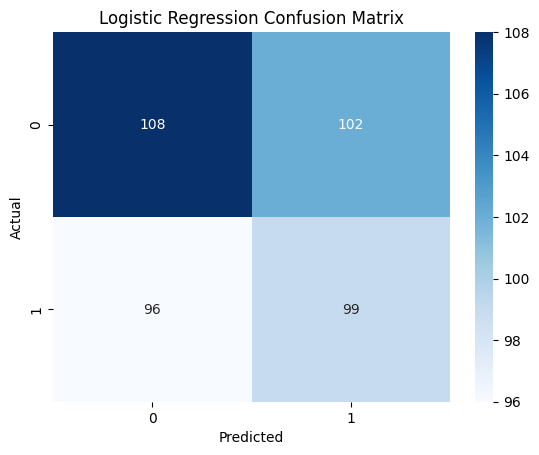


Random Forest Results:
Accuracy: 0.457
F1 Score: 0.593
AUC: 0.470


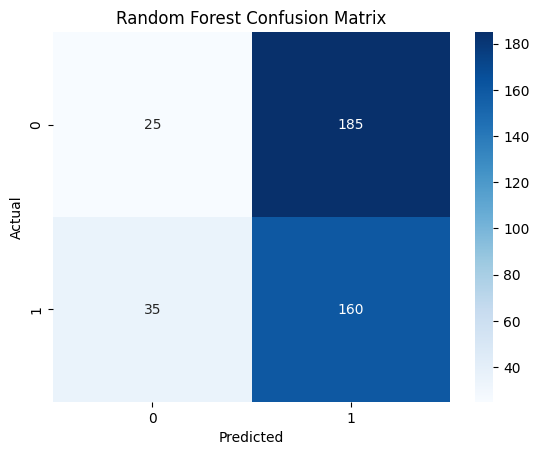

In [12]:
# EVALUATION
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)

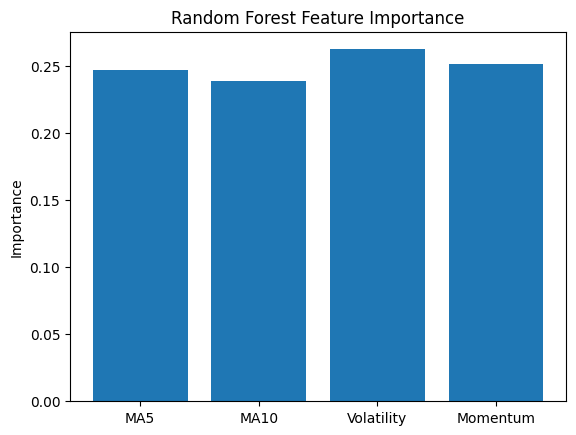

In [13]:
# FEATURE IMPORTANCE(RANDOM FOREST)
importances = rf_model.feature_importances_
plt.bar(features_price, importances)
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()

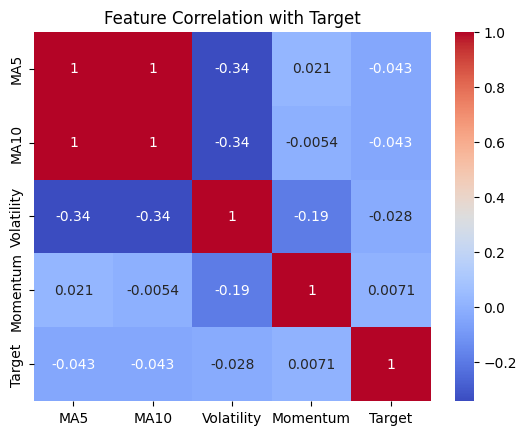

In [14]:
# CORRELATION HEATMAP
sns.heatmap(data_ml[features_price + ['Target']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Target")
plt.show()

In [15]:
# SUMMARY TABLE
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "F1": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf)
    ],
    "AUC": [
        roc_auc_score(y_test, y_pred_log),
        roc_auc_score(y_test, y_pred_rf)
    ]
})
print("\nBaseline Model Performance:")
display(results_df)


Baseline Model Performance:


,Model,Accuracy,F1,AUC
0,Logistic Regression,0.511111,0.500000,0.510989
1,Random Forest,0.456790,0.592593,0.469780


In [16]:
# CREATE SEQUENCES FOR LSTM
X_price_full = scaler.fit_transform(X)
# Hybrid feature with price and embeddings
X_full_hybrid = np.concatenate([X_price_full, news_embs],axis=1)
SEQ_LEN = 30
# Turn daily price and news data into overlapping sequences for LSTM
def create_sequences(X_mat, y_vec, seq_len=SEQ_LEN):
    X_seq_list = []
    y_seq_list = []

    # Slide a 30-day window over the data
    for start in range(0, len(X_mat) - seq_len):
        end = start + seq_len
        # X sequence = 30 days worth of features
        X_seq_list.append(X_mat[start:end])
        # Label = target of the *day after* the sequence window
        y_seq_list.append(y_vec[end])
    X_seq = np.stack(X_seq_list)
    y_seq = np.array(y_seq_list)
    return X_seq, y_seq

# Create both price-only and hybrid sequences
X_seq_price, y_seq = create_sequences(X_price_full, y, SEQ_LEN)
X_seq_hybrid, y_seq_hyb = create_sequences(X_full_hybrid, y, SEQ_LEN)

In [17]:
# TRAIN TEST SPLIT ON SEQUENCES
N_seq = X_seq_price.shape[0]
split_idx = int(0.8 * N_seq) # Split into 80/20 testing training split
# Time respecting split
X_train_price  = X_seq_price[:split_idx]
X_test_price   = X_seq_price[split_idx:]
X_train_hybrid = X_seq_hybrid[:split_idx]
X_test_hybrid  = X_seq_hybrid[split_idx:]
y_train_seq = y_seq[:split_idx]
y_test_seq  = y_seq[split_idx:]

# Wraps sequences in a PyTorch Dataset so DataLoader can batch them
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
batch_size = 64

# Create DataLoaders for batching and shuffling during training
train_dataset_price  = SequenceDataset(X_train_price,  y_train_seq)
test_dataset_price   = SequenceDataset(X_test_price,   y_test_seq)
train_dataset_hybrid = SequenceDataset(X_train_hybrid, y_train_seq)
test_dataset_hybrid  = SequenceDataset(X_test_hybrid,  y_test_seq)
train_loader_price  = DataLoader(train_dataset_price,  batch_size=batch_size, shuffle=True)
test_loader_price   = DataLoader(test_dataset_price,   batch_size=batch_size, shuffle=False)
train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=batch_size, shuffle=True)
test_loader_hybrid  = DataLoader(test_dataset_hybrid,  batch_size=batch_size, shuffle=False)

In [18]:
# LSTM MODEL
class StockLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, bidirectional=False):
        super().__init__()
        self.hidden_size   = hidden_size
        self.bidirectional = bidirectional

        # Main LSTM layer that processes 30 days of features
        self.lstm = nn.LSTM(
            input_size=input_size, # number of features per day
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        lstm_out_dim = hidden_size * (2 if bidirectional else 1)

        # Normalize LSTM output to stabilize training
        self.layer_norm = nn.LayerNorm(lstm_out_dim)

        # Dropout to reduce overfitting
        self.dropout    = nn.Dropout(0.2)

        # Final linear layer predicts 0 or 1 (down or up)
        self.fc = nn.Linear(lstm_out_dim, 1)
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param, gain=0.5)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param, gain=0.5)
            elif "bias" in name:
                nn.init.zeros_(param)
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)

    def forward(self, x):
        # LSTM outputs a hidden state for each timestep
        out, _ = self.lstm(x)

        # Use the final day's output (day 30) to make prediction
        last = out[:, -1, :]

        h = self.layer_norm(last)
        h = self.dropout(h)
        logits = self.fc(h).squeeze(1)
        return logits

# Instantiate models using the new sequence shapes
input_size_price  = X_train_price.shape[2]
input_size_hybrid = X_train_hybrid.shape[2]
model_price  = StockLSTMClassifier(input_size=input_size_price,  hidden_size=64).to(device)
model_hybrid = StockLSTMClassifier(input_size=input_size_hybrid, hidden_size=64).to(device)

In [19]:
# LTSM TRAINING FUNCTION
def train_lstm_model(
    model,
    train_loader,
    test_loader,
    epochs=10,
    lr=1e-3,
    model_name="LSTM"
):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    history = {
        "train_loss": [],
        "test_acc": [],
        "test_f1": [],
        "test_auc": []
    }
    for epoch in range(epochs):
        # Train model
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()               # reset gradients
            logits = model(X_batch)             # forward pass
            loss = criterion(logits, y_batch)   # compute loss

            loss.backward()                     # backprop
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        history["train_loss"].append(avg_loss)

        # Evaluate model
        model.eval()
        all_logits = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(X_batch)
                all_logits.append(logits.cpu())
                all_labels.append(y_batch.cpu())
        all_logits = torch.cat(all_logits).numpy()
        all_labels = torch.cat(all_labels).numpy()
        probs = 1 / (1 + np.exp(-all_logits))
        preds = (probs >= 0.5).astype(int)
        labels_int = all_labels.astype(int)

        # Compute test metrics
        acc = accuracy_score(labels_int, preds)
        f1  = f1_score(labels_int, preds)
        try:
            auc = roc_auc_score(labels_int, probs)
        except ValueError:
            auc = np.nan
        history["test_acc"].append(acc)
        history["test_f1"].append(f1)
        history["test_auc"].append(auc)
        print(f"{model_name} | Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {avg_loss:.4f} "
              f"| Acc: {acc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    # return final metrics from last epoch
    final_metrics = {
        "acc": history["test_acc"][-1],
        "f1":  history["test_f1"][-1],
        "auc": history["test_auc"][-1]
    }
    return history, final_metrics

In [20]:
# TRAIN PRICE LSTM
epochs_lstm = 10
history_price, metrics_price = train_lstm_model(
    model_price,
    train_loader_price,
    test_loader_price,
    epochs=epochs_lstm,
    lr=1e-3,
    model_name="Price-LSTM"
)
acc_lstm_price = metrics_price["acc"]
f1_lstm_price  = metrics_price["f1"]
auc_lstm_price = metrics_price["auc"]

Price-LSTM | Epoch 1/10 | Train Loss: 0.7127 | Acc: 0.464 | F1: 0.539 | AUC: 0.470
Price-LSTM | Epoch 2/10 | Train Loss: 0.7030 | Acc: 0.469 | F1: 0.498 | AUC: 0.456
Price-LSTM | Epoch 3/10 | Train Loss: 0.6958 | Acc: 0.471 | F1: 0.624 | AUC: 0.444
Price-LSTM | Epoch 4/10 | Train Loss: 0.6987 | Acc: 0.449 | F1: 0.582 | AUC: 0.441
Price-LSTM | Epoch 5/10 | Train Loss: 0.6956 | Acc: 0.516 | F1: 0.077 | AUC: 0.485
Price-LSTM | Epoch 6/10 | Train Loss: 0.6941 | Acc: 0.459 | F1: 0.576 | AUC: 0.455
Price-LSTM | Epoch 7/10 | Train Loss: 0.6938 | Acc: 0.506 | F1: 0.299 | AUC: 0.462
Price-LSTM | Epoch 8/10 | Train Loss: 0.6881 | Acc: 0.469 | F1: 0.456 | AUC: 0.456
Price-LSTM | Epoch 9/10 | Train Loss: 0.6967 | Acc: 0.471 | F1: 0.561 | AUC: 0.466
Price-LSTM | Epoch 10/10 | Train Loss: 0.6922 | Acc: 0.471 | F1: 0.561 | AUC: 0.475


In [21]:
# Train LSTM that uses:
# - 30 days of price signals
# - 30 days of FinBERT sentiment embeddings
history_hybrid, metrics_hybrid = train_lstm_model(
    model_hybrid,
    train_loader_hybrid,
    test_loader_hybrid,
    epochs=epochs_lstm,
    lr=1e-3,
    model_name="Hybrid-LSTM"
)
acc_lstm_hybrid = metrics_hybrid["acc"]
f1_lstm_hybrid  = metrics_hybrid["f1"]
auc_lstm_hybrid = metrics_hybrid["auc"]

Hybrid-LSTM | Epoch 1/10 | Train Loss: 0.7605 | Acc: 0.519 | F1: 0.651 | AUC: 0.564
Hybrid-LSTM | Epoch 2/10 | Train Loss: 0.6967 | Acc: 0.541 | F1: 0.610 | AUC: 0.561
Hybrid-LSTM | Epoch 3/10 | Train Loss: 0.6878 | Acc: 0.519 | F1: 0.652 | AUC: 0.561
Hybrid-LSTM | Epoch 4/10 | Train Loss: 0.6902 | Acc: 0.514 | F1: 0.657 | AUC: 0.553
Hybrid-LSTM | Epoch 5/10 | Train Loss: 0.6872 | Acc: 0.511 | F1: 0.657 | AUC: 0.557
Hybrid-LSTM | Epoch 6/10 | Train Loss: 0.6819 | Acc: 0.519 | F1: 0.608 | AUC: 0.554
Hybrid-LSTM | Epoch 7/10 | Train Loss: 0.6743 | Acc: 0.509 | F1: 0.125 | AUC: 0.553
Hybrid-LSTM | Epoch 8/10 | Train Loss: 0.6831 | Acc: 0.536 | F1: 0.545 | AUC: 0.544
Hybrid-LSTM | Epoch 9/10 | Train Loss: 0.6742 | Acc: 0.539 | F1: 0.636 | AUC: 0.544
Hybrid-LSTM | Epoch 10/10 | Train Loss: 0.6637 | Acc: 0.546 | F1: 0.557 | AUC: 0.548


In [22]:
# FINAL MODEL COMPARISON TABLE
results_df = pd.DataFrame({
    "Model": [
        "Logistic Regression (Indicators)",
        "Random Forest (Indicators)",
        "LSTM (Price Sequence)",
        "Hybrid LSTM (Price + News)"
    ],
    "Accuracy": [
        acc_log,
        acc_rf,
        acc_lstm_price,
        acc_lstm_hybrid
    ],
    "F1-Score": [
        f1_log,
        f1_rf,
        f1_lstm_price,
        f1_lstm_hybrid
    ],
    "AUC": [
        auc_log,
        auc_rf,
        auc_lstm_price,
        auc_lstm_hybrid
    ]
})
print("FINAL MODEL COMPARISON:\n")
display(results_df)

FINAL MODEL COMPARISON:



,Model,Accuracy,F1-Score,AUC
0,Logistic Regression (Indicators),0.511111,0.500000,0.510989
1,Random Forest (Indicators),0.456790,0.592593,0.469780
2,LSTM (Price Sequence),0.471178,0.561331,0.475191
3,Hybrid LSTM (Price + News),0.546366,0.557457,0.547932
